# Classification in Data Streams

The goal of this lab is to build a classifier capable of learning and making predictions in a datastream using the `River` library. In this lab we are comparing three datastream classifiers on Electricity dataset:
- kNN
- Hoeffding Tree
- Batch-Incremental Ensemble Classifier (BIE)

batchClassifier waits 100 sample modoel, than train the model, adds another 100 points and trains the model again untill 100 max models and after the olders model is removed

In [7]:
from sklearn.tree import DecisionTreeClassifier
from statistics import mode
from river.utils import dict2numpy
from river import datasets
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

class BatchClassifier:
    """
    initialize attributes 
    """
    def __init__(self, window_size=100, max_models=100):
        self.H = []
        self.h = None
        # TODO
        self.window_size = window_size
        self.max_models = max_models
        self.init = False
        self.X_batch = []
        self.y_batch = []
        
    def learn_one(self, x, y=None):
        """
        once new 100 data points are fed the model are trained and the models are appended it to the ensemble
        """
        self.X_batch.append(dict2numpy(x))
        self.y_batch.append(y)
        if len(self.X_batch)==self.window_size:
            h = DecisionTreeClassifier()
            
            h.fit(self.X_batch, self.y_batch)
            self.H.append(h) 
            
            self.X_batch.clear()
            self.y_batch.clear()
        if len(self.H)>self.max_models:
            self.H.pop(0)
        return self

    def predict_one(self, x):
        """
        prediction is made by every model in ensemble and outputs with majority rule.
        """
        if len(self.H)==0:
            return 0
        preds = []
        for model in self.H:
            preds.append(model.predict([dict2numpy(x)]))
        preds = [x[0] for x in preds]
        return mode(preds)

## Evaluation

In [2]:
import time
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics

import pandas as pd

dataset = "elec"

def print_progress(sample_id, acc, kappa,training_time,testing_time):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)
    print("total train time:" , training_time)
    print("total testing time:",testing_time)

def evaluate(stream, model, n_wait=1000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = metrics.Rolling(metric=metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = metrics.Rolling(metric=metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    list_of_trainings = []
    list_of_testings = []
    
    training_time = 0
    testing_time = 0
    for i, (x, y) in enumerate(stream):
        # Predict
        start = time.time()
        y_pred = model.predict_one(x)
        end = time.time()
        testing_time = end-start
        list_of_testings.append(testing_time)
        
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get(),training_time,testing_time])
        # Learn (train)
        start = time.time()
        model.learn_one(x, y)
        end = time.time()
        training_time =  end-start
        list_of_trainings.append(training_time)
        
    print_progress(i, acc, kappa,sum(list_of_trainings),sum(list_of_testings))
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll','training_time','testing_time'])

# Load the data, will be transformed into a stream later
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

# Initialize models
knn = KNNClassifier(n_neighbors=10, window_size=100)
ht = HoeffdingTreeClassifier()
bie = BatchClassifier(window_size=100, max_models=100)

### Run experiments

Note that we convert the stream (`iter_pandas`) on each call to `evaluate`, this ensures that we are passing the stream properly initialized.

In [3]:
knn_results = evaluate(stream=iter_pandas(X=X, y=Y),
                       model=knn)

Samples processed: 45310
Accuracy: 77.97%
CohenKappa: 0.546698
total train time: 0.9085023403167725
total testing time: 7.112596273422241


In [4]:
ht_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=ht)

Samples processed: 45310
Accuracy: 77.53%
CohenKappa: 0.533719
total train time: 4.340327739715576
total testing time: 1.5569839477539062


In [5]:
bie_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=bie)

Samples processed: 45310
Accuracy: 75.34%
CohenKappa: 0.488856
total train time: 0.8433632850646973
total testing time: 298.9330520629883


## Generate plots

The code below uses the raw results from the `evaluate` method to generate the plots for `accuracy` and `kappa` and generates a `pdf` file. 

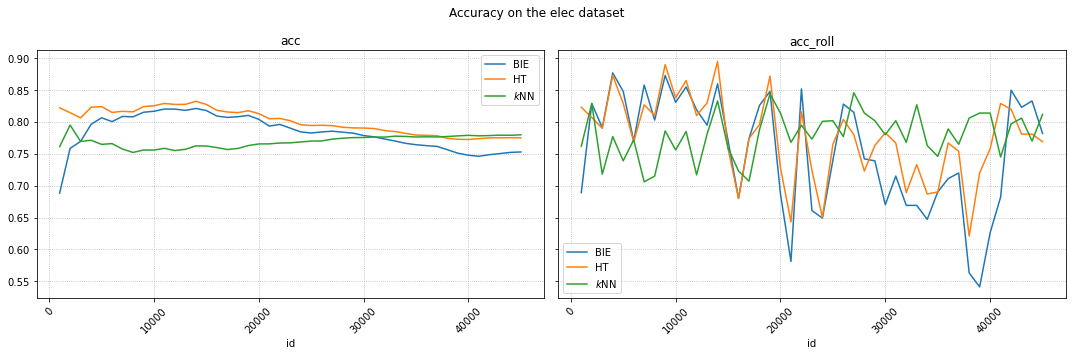

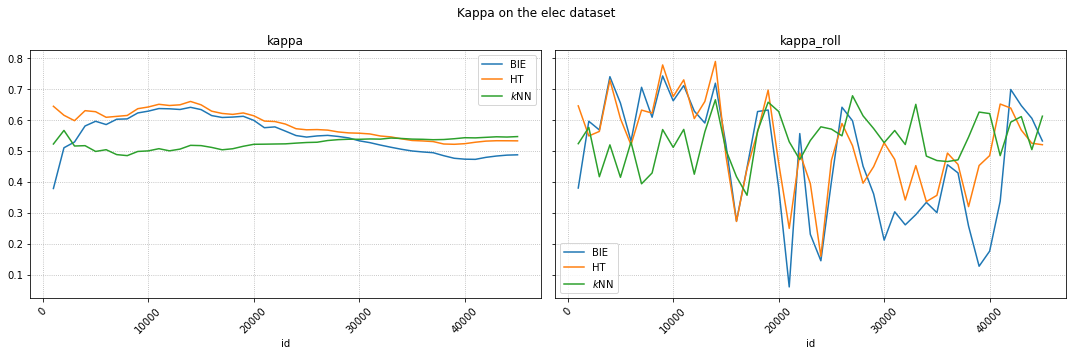

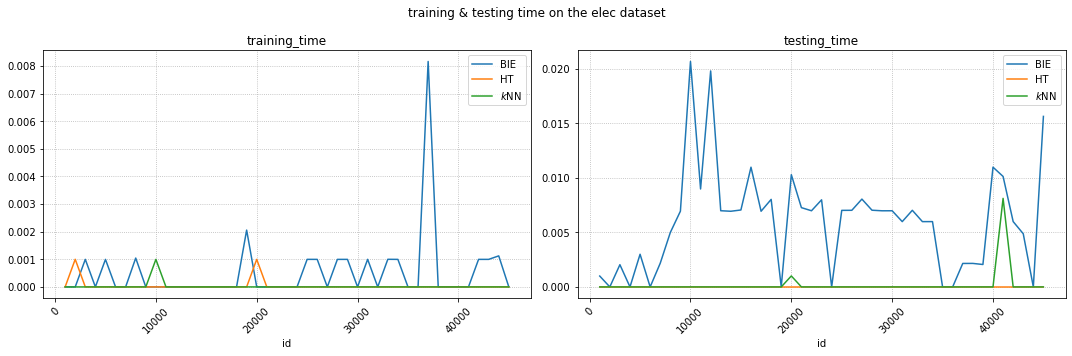

In [8]:
dataset = "elec"
df = pd.concat([knn_results, ht_results, bie_results])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['kappa', 'kappa_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    #training + testing time prot
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=False)
    for metric, ax in zip(['training_time', 'testing_time'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("training & testing time on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page


In [15]:
!pigar

11:21:08 parse C:\Users\gkere\Desktop\IP Paris\M1 classes - IP Paris\20) Dataai962 - Data Stream Mining\2) lab-river\lab2\IoT_Stream_Data_Mining_Lab_2.ipynb:1 failed: SyntaxError('invalid syntax', ('<unknown>', 160, 1, '!pigar\n'))
Traceback (most recent call last):
  File "c:\users\gkere\anaconda\lib\site-packages\nbformat\__init__.py", line 138, in read
    buf = fp.read()
AttributeError: 'str' object has no attribute 'read'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\gkere\anaconda\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\gkere\anaconda\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\gkere\anaconda\Scripts\pigar.exe\__main__.py", line 7, in <module>
  File "c:\users\gkere\anaconda\lib\site-packages\pigar\__main__.py", line 167, in main
    RequirementsGenerator(
  File "c:\users\gkere\anaconda\lib\site-